# Algoritmo TCC

Este notebook foi executado no seguinte ambiente
* Python 3.7.X
* Jypyter Notebook 2.1.2
* pandas 1.0.3
* numpy 1.18.4

Antes de executar verifique os requisitos acima e descomprima o arquivo <code>datasets_consolidados.zip</code>.

In [264]:
import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Carrega arquivos originais de temperatura e log de servidores.

In [265]:
temp = pd.read_csv('datasets_consolidados/servidores-inlettemp.csv')
logs = pd.read_csv('datasets_consolidados/logs_servidores.csv')

Uma amostra das bases de logs e temperatura de servidores em estado original

In [266]:
temp

,Server,Average,Peak,Time
0,server01,21,22,Fri Dec 20 21:10:46 2013
1,server01,-128,-128,Fri Dec 20 22:10:46 2013
2,server01,-128,-128,Fri Dec 20 23:10:46 2013
3,server01,-128,-128,Sat Dec 21 00:10:46 2013
4,server01,-128,-128,Sat Dec 21 01:10:46 2013
...,...,...,...,...
1541371,server30,19,20,Thu Jan 2 06:01:57 2020
1541372,server30,19,20,Thu Jan 2 07:01:57 2020
1541373,server30,19,21,Thu Jan 2 08:01:57 2020
1541374,server30,18,21,Thu Jan 2 09:01:57 2020


In [267]:
logs

,Server,Severity,Date,Description
0,server01,Normal,Fri Dec 20 2013 20:15:46,Log cleared.
1,server01,Critical,Mon Mar 31 2014 14:24:53,The power input for power supply 2 is lost.
2,server01,Critical,Mon Mar 31 2014 14:25:04,Power supply redundancy is lost.
3,server01,Normal,Mon Mar 31 2014 13:29:08,The input power for power supply 2 has been re...
4,server01,Normal,Mon Mar 31 2014 13:29:13,The power supplies are redundant.
...,...,...,...,...
6363,server30,Critical,Tue May 21 2019 13:35:57,Power supply redundancy is lost.
6364,server30,Normal,Tue May 21 2019 20:05:01,The input power for power supply 2 has been re...
6365,server30,Normal,Tue May 21 2019 20:05:07,The power supplies are redundant.
6366,server30,Critical,Sun Jul 28 2019 06:42:53,The power input for power supply 1 is lost.


Remove as não-ocorrências de temperatura, ou seja, o servidor está desligado e isso é evidenciado com o atributo <code>Average</code> em -128.

In [268]:
temp.drop(temp.index[temp['Average'] == -128], inplace = True)

Transforma o atributo <code>Time</code> em tipo Date and cria um atributo <code>DateOnly</code> para posteriores comparações entre bases.

In [269]:
temp['Time']= pd.to_datetime(temp['Time'], format="%a %b %d %H:%M:%S %Y")
temp['DateOnly'] = temp['Time'].dt.date

Ordena a base de temperaturas em função do nome do servidor e do dia/hora.

In [270]:
temp.sort_values(by=['Server', 'Time'])

,Server,Average,Peak,Time,DateOnly
0,server01,21,22,2013-12-20 21:10:46,2013-12-20
2448,server01,19,30,2014-04-01 22:10:47,2014-04-01
2449,server01,27,30,2014-04-01 23:10:47,2014-04-01
2450,server01,25,28,2014-04-02 00:10:47,2014-04-02
2451,server01,25,28,2014-04-02 01:10:47,2014-04-02
...,...,...,...,...,...
1541371,server30,19,20,2020-01-02 06:01:57,2020-01-02
1541372,server30,19,20,2020-01-02 07:01:57,2020-01-02
1541373,server30,19,21,2020-01-02 08:01:57,2020-01-02
1541374,server30,18,21,2020-01-02 09:01:57,2020-01-02


Agrupa as linhas em função do nome de servidor e data, sumariza atráves do agrupamento os atributos <code>Average</code> e <code>Peak</code> com informações de Minímo, Máximo, Média, Mediana, Variância e Desvio Padrão.

In [271]:
temp_summary = temp.groupby(['Server','DateOnly'])[['Average','Peak']].agg(['min', 'max','mean','median','var','std']).reset_index()

A operação de groupby adiciona uma nova linha de indíces, pra isso é necessário realizar um ajuste para se manter uma só linha de índice sem perda de identidade das colunas.

In [272]:
temp_summary.columns = ["_".join(x) for x in temp_summary.columns.ravel()]
temp_summary.rename(columns={'Server_':'Server','DateOnly_':'DateOnly'},inplace=True)

Remove as ocorrências da base de logs aonde a data tem formato inválido pois indica o System Boot da máquina e transforma o atributo <code>Date</code> em tipo Date.

In [273]:
logs.drop(logs.index[logs['Date'] == 'System Boot'], inplace = True)
logs['Date']= pd.to_datetime(logs['Date'], format="%a %b %d %Y %H:%M:%S")

Cria o atributo <code>DateOnly</code> e orderna a base de logs em função do nome do servidor e o dia.

In [274]:
logs['DateOnly'] = logs['Date'].dt.date # creates a Date only column
logs.sort_values(by=['Server', 'Date']) # make is sorted

,Server,Severity,Date,Description,DateOnly
0,server01,Normal,2013-12-20 20:15:46,Log cleared.,2013-12-20
3,server01,Normal,2014-03-31 13:29:08,The input power for power supply 2 has been re...,2014-03-31
4,server01,Normal,2014-03-31 13:29:13,The power supplies are redundant.,2014-03-31
5,server01,Critical,2014-03-31 14:10:45,The power input for power supply 2 is lost.,2014-03-31
6,server01,Critical,2014-03-31 14:10:50,Power supply redundancy is lost.,2014-03-31
...,...,...,...,...,...
6363,server30,Critical,2019-05-21 13:35:57,Power supply redundancy is lost.,2019-05-21
6364,server30,Normal,2019-05-21 20:05:01,The input power for power supply 2 has been re...,2019-05-21
6365,server30,Normal,2019-05-21 20:05:07,The power supplies are redundant.,2019-05-21
6366,server30,Critical,2019-07-28 06:42:53,The power input for power supply 1 is lost.,2019-07-28


Combina as duas bases em uma só usando como índice o nome do servidor e o dia. Para cada ocorrência de log será concatenado os atributos de temperatura do servidor no dia.

In [275]:
merged2 = pd.merge(temp_summary,logs, on=['Server', 'DateOnly'], how='left') # merge two dataframes

Substitui o valores vazios (ausência de registro de log) da coluna "Severity" com o valor "Normal"

In [276]:
merged2.Severity.fillna("NoneAlert", inplace=True)

Adiciona o atributo categórico TempSala que indica se a sala de servidores estava quente, esquentando ou fria.

In [277]:
merged2.loc[merged2['Peak_max'] <= 26, 'TempSala'] = 'SalaFria'
merged2.loc[(merged2['Peak_max'] > 26) & (merged2['Peak_max'] <= 33), 'TempSala'] = 'SalaEsquentando'
merged2.loc[merged2['Peak_max'] > 33, 'TempSala'] = 'SalaQuente'

Amostra da base combinada

In [278]:
merged2

,Server,DateOnly,Average_min,Average_max,Average_mean,Average_median,Average_var,Average_std,Peak_min,Peak_max,Peak_mean,Peak_median,Peak_var,Peak_std,Severity,Date,Description,TempSala
0,server01,2013-12-20,21,21,21.000000,21.0,NaN,NaN,22,22,22.000000,22.0,NaN,NaN,Normal,2013-12-20 20:15:46,Log cleared.,SalaFria
1,server01,2014-04-01,19,27,23.000000,23.0,32.000000,5.656854,30,30,30.000000,30.0,0.000000,0.000000,Critical,2014-04-01 22:16:12,Power supply redundancy is lost.,SalaEsquentando
2,server01,2014-04-01,19,27,23.000000,23.0,32.000000,5.656854,30,30,30.000000,30.0,0.000000,0.000000,Critical,2014-04-01 22:16:17,The power input for power supply 2 is lost.,SalaEsquentando
3,server01,2014-04-02,16,27,21.500000,24.0,16.086957,4.010855,18,30,25.625000,28.0,13.461957,3.669054,NoneAlert,NaT,NaN,SalaEsquentando
4,server01,2014-04-03,17,23,18.625000,17.0,5.635870,2.373999,18,31,23.416667,22.0,21.557971,4.643056,NoneAlert,NaT,NaN,SalaEsquentando
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65969,server30,2019-12-29,18,19,18.583333,19.0,0.253623,0.503610,19,21,20.125000,20.0,0.201087,0.448427,NoneAlert,NaT,NaN,SalaFria
65970,server30,2019-12-30,18,21,19.125000,19.0,0.288043,0.536697,20,23,20.708333,21.0,0.650362,0.806450,NoneAlert,NaT,NaN,SalaFria
65971,server30,2019-12-31,18,20,18.958333,19.0,0.128623,0.358641,20,22,20.208333,20.0,0.259058,0.508977,NoneAlert,NaT,NaN,SalaFria
65972,server30,2020-01-01,18,19,18.791667,19.0,0.172101,0.414851,20,20,20.000000,20.0,0.000000,0.000000,NoneAlert,NaT,NaN,SalaFria


O atributo Severity será útil ao executar alguns modelos como o PCA na base merged, mas a maioria dos modelos requer que atributos categoricos sejam transformados em inteiros. Para isso, utilizaremos a técnica de One-Hot Encoding para isso.

Abaixo podemos visualizar os possíveis valores para Severity.


In [279]:
merged2.Severity.unique()

array(['Normal', 'Critical', 'NoneAlert', 'Warning'], dtype=object)

Cria-se um dataset com os valores possíveis e utilizamos a função pd.get_dummies() para gerar as colunas numéricas.

In [280]:
df = pd.DataFrame({'Severity': ['NoneAlert','Normal', 'Critical', 'Warning']})
merged2 = pd.concat([merged2,pd.get_dummies(merged2['Severity'], prefix='Severity')],axis=1)

Uma amostra dos novos atributos.

In [281]:
merged2.filter(regex=("Severity_*"))

,Severity,Severity_Critical,Severity_NoneAlert,Severity_Normal,Severity_Warning
0,Normal,0,0,1,0
1,Critical,1,0,0,0
2,Critical,1,0,0,0
3,NoneAlert,0,1,0,0
4,NoneAlert,0,1,0,0
...,...,...,...,...,...
65969,NoneAlert,0,1,0,0
65970,NoneAlert,0,1,0,0
65971,NoneAlert,0,1,0,0
65972,NoneAlert,0,1,0,0


Exporta as bases para CSV

In [282]:
#temp.to_csv(r'datasets_consolidados/temperatura.csv', index = False) # export all datasets
#logs.to_csv(r'datasets_consolidados/logs.csv', index = False)
#merged.to_csv(r'datasets_consolidados/merged.csv', index = False)
merged2.to_csv(r'datasets_consolidados/merged2.csv', index = False)

## Avaliando dados com PCA

Frequência de atributos importantes

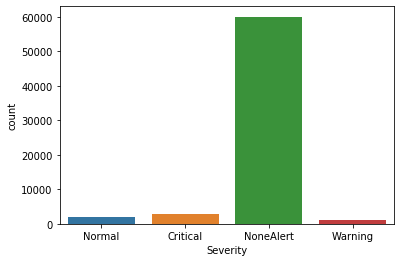

In [283]:
import seaborn as sns
Severity = sns.countplot(merged2['Severity'])

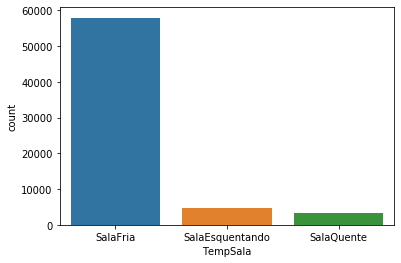

In [284]:
TempSala = sns.countplot(merged2['TempSala'])

Mostra a matriz de correlação entre os atributos núméricos. Cores quentes (vermelho) indicam uma correlação positiva, cores frias (azul) indicam uma correlação negativa.


Text(0.5, 1, 'Matriz de Correlação')

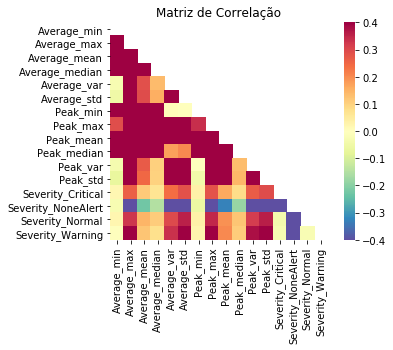

In [287]:
corrs = merged2.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', mask=mask, square=True, vmin=-.4, vmax=.4)
plt.title('Matriz de Correlação')



Usando a temperatura Média (min/max) e Picos (min/max) como features e normalizando os valores

In [254]:
features = ['Average_min','Average_max','Peak_min','Peak_max']
# Separating out the features
x = merged2.loc[:, features].values
# Separating out the target
y = merged2.loc[:,['Severity']].values

x = StandardScaler().fit_transform(x)
pd.DataFrame(data = x, columns = features).head()

,Average_min,Average_max,Peak_min,Peak_max
0,0.685620,-0.020700,0.407949,-0.284166
1,0.079956,0.927688,3.426023,0.882074
2,0.079956,0.927688,3.426023,0.882074
3,-0.828540,0.927688,-1.101087,0.882074
4,-0.525708,0.295429,-1.101087,1.027854


In [255]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Executar o PCA

In [256]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head(5)

,principal component 1,principal component 2
0,0.397870,-0.717498
1,2.669817,-0.802472
2,2.669817,-0.802472
3,-0.053232,1.853542
4,-0.170447,1.511094


Dataset com os componentes e o target

In [257]:
finalDf = pd.concat([principalDf, merged2[['Severity']]], axis = 1)
finalDf.head(5)

,principal component 1,principal component 2,Severity
0,0.397870,-0.717498,Normal
1,2.669817,-0.802472,Critical
2,2.669817,-0.802472,Critical
3,-0.053232,1.853542,NoneAlert
4,-0.170447,1.511094,NoneAlert


Plotando o gráfico

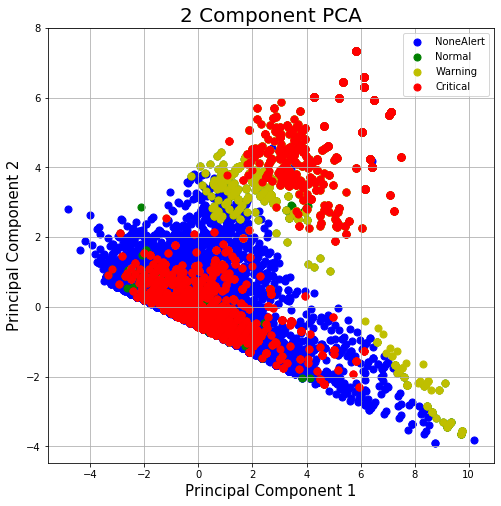

In [258]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [ 'NoneAlert','Normal', 'Warning','Critical']
colors = [ 'b','g', 'y','r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Severity'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Criando base de treino e teste 70% treino e 30% teste

In [259]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

Normaliza os atributos

In [260]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Roda o classificador de árvore de decisão.

In [261]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_pred

array(['Critical', 'NoneAlert', 'NoneAlert', ..., 'NoneAlert',
       'NoneAlert', 'NoneAlert'], dtype=object)

In [262]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9246198150861415


Matrix de confusão

In [263]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[  198,   450,   102,    56],
       [   87, 17971,     7,     1],
       [  124,   282,    73,    89],
       [  114,    46,   134,    59]])